# Citation network topic modeling
In this notebook, we'll implement topic modeling on the various categories in the desiccation tolerance citation network

In [1]:
import jsonlines
import networkx as nx
import sys
sys.path.append('../desiccation_network/conference_recommendation')
sys.path.append('../data/')
from openai_key import API_KEY
import utils
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import MaximalMarginalRelevance, KeyBERTInspired, PartOfSpeech, OpenAI
import openai
from ast import literal_eval
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from transformers.pipelines import pipeline
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import umap.plot
import sklearn

2024-02-01 11:08:58.282267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-01 11:08:58.440991: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.re

## Read in data
For now, doing this for main result network only (ignoring unclassified other references).

In [2]:
with jsonlines.open('../data/wos_files/core_collection_destol_or_anhydro_FILTERED_MAIN_ONLY_with_ref_abstracts_05Jan2023.jsonl') as reader:
    data = []
    for obj in reader:
        data.append(obj)

In [3]:
class_graph = nx.read_graphml('../data/citation_network/core_collection_destol_or_anhydro_FILTERED_classified_network_06Jan2023_MANUALLY_VERIFIED.graphml')

Map classifications from the graph to the dataset with abstracts:

In [4]:
data_with_class = utils.map_classes_to_jsonl(class_graph, data, False, 'UID')

In [5]:
abstracts_and_classes = {'UID': [], 'abstract': [], 'study_system': [], 'year': []}
for paper in data_with_class:
    abstracts_and_classes['UID'].append(paper['UID'])
    abstracts_and_classes['abstract'].append(paper['abstract'])
    abstracts_and_classes['study_system'].append(paper['study_system'])
    abstracts_and_classes['year'].append(int(paper['year']))
abstracts = pd.DataFrame.from_dict(abstracts_and_classes, orient='columns').set_index('UID')
print(f'There are {len(abstracts)} abstracts in the dataset.')
abstracts.head()

There are 5564 abstracts in the dataset.


abstract  \
UID                                                                      
WOS:A1990ET59600010  Four sorghum (Sorghum bicolor L. Moench) lines...   
WOS:000244317000009  Cynanchum komarovii is well adapted to hot and...   
WOS:000249421700004  Synergies between global change and biological...   
WOS:000251161900001  Desiccation tolerance (DT), or the capacity to...   
WOS:000244031100003  Bean seed storage ability is of major interest...   

                    study_system  year  
UID                                     
WOS:A1990ET59600010        Plant  1990  
WOS:000244317000009        Plant  2007  
WOS:000249421700004       Animal  2007  
WOS:000251161900001        Plant  2007  
WOS:000244031100003        Plant  2007

## Initialize embedding model
We can use [literally any embedding model we want](https://maartengr.github.io/BERTopic/getting_started/embeddings/embeddings.html#sentence-transformers). We're going to use SciBERT as our first choice.

In [6]:
sentence_model = SentenceTransformer('allenai/scibert_scivocab_cased')

No sentence-transformers model found with name /mnt/home/lotrecks/.cache/torch/sentence_transformers/allenai_scibert_scivocab_cased. Creating a new one with MEAN pooling.
Some weights of the model checkpoint at /mnt/home/lotrecks/.cache/torch/sentence_transformers/allenai_scibert_scivocab_cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be 

## Choose dimensionality reduction model
There are many [dimensionality reduction models](https://maartengr.github.io/BERTopic/getting_started/dim_reduction/dim_reduction.html) to choose from. We're going to start with the default UMAP and its default parameters, but we need to set a random seed so that we can reliably reproduce our results.

In [7]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

## Pre-calculate embeddings
BERTopic recommends [pre-computing embeddings](https://maartengr.github.io/BERTopic/getting_started/best_practices/best_practices.html#data) to reduce computational intensity; this also allows us to make certain visualizations iteratively during the outlier reduction process.

In [8]:
docs = abstracts.abstract.values.tolist()

In [9]:
embeddings = sentence_model.encode(docs, show_progress_bar=True)

# We reduce our embeddings to 2D as it will allows us to quickly iterate later on
reduced_embeddings = umap_model.fit_transform(embeddings)

Batches:   0%|          | 0/174 [00:00<?, ?it/s]

## Choose clustering model
There are many [clustering models](https://maartengr.github.io/BERTopic/getting_started/clustering/clustering.html) to choose from. We started with the default HDBSCAN and its default parameters, so no action is required here.

## Choose vectorizer
The [vectorizer](https://maartengr.github.io/BERTopic/getting_started/vectorizers/vectorizers.html) can be passed either before or after training. Passing before allows you to reduce the overall memory needed, while passing after allows you to fine tune the topics. Initially, we passed it after training, but some of the topic representation modelswe tested were negatively impacted by doing this; so we also define it here.

In [10]:
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)

## Choose representation model
We can improve our topic representations with different topic representation methods. We tried a few and looked at the largest topics and heuristically chose the best one, which was using ChatGPT.

In [11]:
client = openai.OpenAI(api_key=API_KEY)
representation_model = OpenAI(client, "gpt-3.5-turbo", chat=True)

## Train overall topic model
Now that we've set up our basic inputs, we can train our topic models. We're going to do several groups of topic models, but we'll start with the entire dataset together.

In [12]:
# topic_model = BERTopic(embedding_model=sentence_model, umap_model=umap_model, representation_model=representation_model, vectorizer_model=vectorizer_model)
# topics, probs = topic_model.fit_transform(docs, embeddings)

In [16]:
# topic_model.save('../data/toipc_models/initial_model_with_outliers_01Feb', serialization="pytorch", save_ctfidf=True, save_embedding_model=sentence_model)

In [11]:
# Load back in saved model
topic_model = BERTopic.load('../data/toipc_models/initial_model_with_outliers_01Feb')

2024-02-01 11:10:29,879 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


In [12]:
topic_model.get_topic_info()[:10]

Topic  Count                                               Name  \
0     -1   2522   -1_Understanding Desiccation Tolerance in Plants   
1      0    476  0_Seed Germination and Storage Characteristics...   
2      1    358  1_Molecular Basis of Desiccation Tolerance and...   
3      2    201  2_Cryopreservation and maturation of somatic e...   
4      3    144  3_Understanding desiccation tolerance mechanis...   
5      4    118  4_Tardigrade radiation tolerance and survival ...   
6      5    116     5_Desiccation tolerance in foodborne pathogens   
7      6    108  6_Drought tolerance and grain yield in wheat, ...   
8      7     93  7_Thermal Limits and Habitat Distribution of I...   
9      8     84  8_Study of protein expression and gene regulat...   

                                      Representation  Representative_Docs  
0    [Understanding Desiccation Tolerance in Plants]                  NaN  
1  [Seed Germination and Storage Characteristics ...                  NaN  
2  [Molecular Basis of Desiccation Tolerance and ...                  NaN  
3  [Cryopreservation and maturation of somatic em...                  NaN  
4  [Understanding desiccation tolerance mechanism...                  NaN  
5  [Tardigrade radiation tolerance and survival i...                  NaN  
6     [Desiccation tolerance in foodborne pathogens]                  NaN  
7  [Drought tolerance and grain yield in wheat, s...                  NaN  
8  [Thermal Limits and Habitat Distribution of In...                  NaN  
9  [Study of protein expression and gene regulati...                  NaN

In [13]:
topic_model.get_topic_info().shape

(53, 5)

In [14]:
topic_model.visualize_topics()

## Fine-tune topic representations
There are lots of stopwords in our final topic representations when we use non-LLM methods. The commented-out code below is for performing a fine-tuning to remove stopwords for models that need it.

In [20]:
# vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)
# topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [21]:
# topic_model.get_topic_info()[:10]

In [22]:
# topic_model.visualize_topics()

Much better! And the topic groups, while clearly redundant as they overlap in the embedding space, are still reasonably well separated in meta-groups. We can play around with more hyperparameters to try and reduce the number of outliers.

## Reducing outliers
There are ~3,000 outliers, which we can assign to clusters using the reduce outliers functionality of BERTopic. Before we decide how many outliers to reduce, let's take a look at a visualization:

In [23]:
fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)
fig.update_layout(showlegend=False)

There are several strategies to reduce outliers, and we can also set a threshold so that we don't reduce all outliers, which is [inadvisable](https://github.com/MaartenGr/BERTopic/discussions/1738#discussioncomment-8111002) as it doesn't necessarily make semantic sense to do so. Therefore, we'll take a look at various thresholds and strategies and see how it impacts the result.

In [24]:
# new_topics = topic_model.reduce_outliers(docs, topics, strategy='embeddings', threshold=0.1)

In [25]:
# topic_model.update_topics(docs, topics=new_topics, vectorizer_model=vectorizer_model, representation_model=representation_model)

2024-02-01 11:02:39,260 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


In [27]:
# topic_model.save('../data/topic_models/model_with_embedding_reduced_outliers_01Feb2024', serialization="pytorch", save_ctfidf=True, save_embedding_model=sentence_model)

In [15]:
topic_model = BERTopic.load('../data/topic_models/model_with_embedding_reduced_outliers_01Feb2024')

2024-02-01 11:11:12,545 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model.If you want to also load in an embedding model, make sure to useBERTopic.load(my_model, embedding_model=my_embedding_model).


In [16]:
fig = topic_model.visualize_documents(docs, reduced_embeddings=reduced_embeddings, 
                                hide_document_hover=True, hide_annotations=True)
fig.update_layout(showlegend=False)

In [17]:
topic_model.get_topic_info()[:10]

Topic  Count                                               Name  \
0      0    589  0_Seed Germination and Desiccation Tolerance i...   
1      1    491  1_Understanding mechanisms of desiccation tole...   
2      2    227  2_Somatic embryogenesis and maturation in coni...   
3      3    272  3_Photosynthetic and Physiological Adaptations...   
4      4    221  4_Radiations tolerance in anhydrobiotic tardig...   
5      5    161     5_Desiccation tolerance in bacterial pathogens   
6      6    156  6_Drought tolerance and water relations in dif...   
7      7    202  7_Adaptation to abiotic stress in intertidal s...   
8      8    170  8_Analysis of gene expression and protein patt...   
9      9    113  9_Role of LEA Proteins in Stress Tolerance and...   

                                      Representation  Representative_Docs  
0  [Seed Germination and Desiccation Tolerance in...                  NaN  
1  [Understanding mechanisms of desiccation toler...                  NaN  
2  [Somatic embryogenesis and maturation in conif...                  NaN  
3  [Photosynthetic and Physiological Adaptations ...                  NaN  
4  [Radiations tolerance in anhydrobiotic tardigr...                  NaN  
5     [Desiccation tolerance in bacterial pathogens]                  NaN  
6  [Drought tolerance and water relations in diff...                  NaN  
7  [Adaptation to abiotic stress in intertidal sp...                  NaN  
8  [Analysis of gene expression and protein patte...                  NaN  
9  [Role of LEA Proteins in Stress Tolerance and ...                  NaN

## Map classifications to topics
We want to see what proportion of each topic is made up of each class, to see if there are some that are more dominated by one group or another. We would expect to see the same proportions as the overall graph if there were no difference in topics in each discipline, so major departures from those splits are what we're looking for.

In [18]:
topic_system_map = topic_model.get_document_info(docs)
topic_system_map['UID'] = abstracts.index
topic_system_map['study_system'] = abstracts['study_system'].values.tolist()
topic_system_map.head()

Document  Topic  \
0  Four sorghum (Sorghum bicolor L. Moench) lines...      6   
1  Cynanchum komarovii is well adapted to hot and...      3   
2  Synergies between global change and biological...     13   
3  Desiccation tolerance (DT), or the capacity to...     32   
4  Bean seed storage ability is of major interest...      0   

                                                Name  \
0  6_Drought tolerance and water relations in dif...   
1  3_Photosynthetic and Physiological Adaptations...   
2  13_Physiological traits and responses to clima...   
3  32_Proteomic and Genomic Analysis of Dehydrati...   
4  0_Seed Germination and Desiccation Tolerance i...   

                                      Representation  Representative_Docs  \
0  [Drought tolerance and water relations in diff...                  NaN   
1  [Photosynthetic and Physiological Adaptations ...                  NaN   
2  [Physiological traits and responses to climate...                  NaN   
3  [Proteomic and Genomic Analysis of Dehydration...                  NaN   
4  [Seed Germination and Desiccation Tolerance in...                  NaN   

                                         Top_n_words  Representative_document  \
0  Drought tolerance and water relations in diffe...                    False   
1  Photosynthetic and Physiological Adaptations t...                    False   
2  Physiological traits and responses to climate ...                    False   
3  Proteomic and Genomic Analysis of Dehydration ...                    False   
4  Seed Germination and Desiccation Tolerance in ...                    False   

                   UID study_system  
0  WOS:A1990ET59600010        Plant  
1  WOS:000244317000009        Plant  
2  WOS:000249421700004       Animal  
3  WOS:000251161900001        Plant  
4  WOS:000244031100003        Plant

In [30]:
topic_system_map.study_system.value_counts().to_dict()

{'Plant': 3627, 'Animal': 1176, 'Microbe': 620, 'Fungi': 141}

In [31]:
topic_counts = topic_system_map['Topic'].value_counts().to_dict()

In [26]:
unique_topics = topic_system_map.drop_duplicates(subset=['Topic'])
unique_topics['joined_rep'] = unique_topics['Representation'].str.join(' | ')
topic_reps = unique_topics.set_index('Topic')['joined_rep'].to_dict()

In [33]:
topic_reps[48]

'Trehalose synthesis and its role in stress response'

In [34]:
topic_reps[4]

'Radiations tolerance in anhydrobiotic tardigrades'

## Visualize class distribution in topic clusters

In [20]:
classes = list(topic_system_map['study_system'].unique())
classes

['Plant', 'Animal', 'Microbe', 'Fungi']

In [21]:
bars = defaultdict(list)
topic_order = []
for i in topic_system_map['Topic'].unique():
    bars['topic'].append(i)
    topic_df = topic_system_map[topic_system_map['Topic'] == i]
    group_counts = topic_df.study_system.value_counts()
    total_count = len(topic_df)
    group_props = {k: v/total_count for k, v in group_counts.items()}
    for k, v in group_props.items():
        bars[k].append(v)
    if len(group_props.keys()) != 5:
        for system in classes:
            if system not in group_props.keys():
                bars[system].append(0.0)
bars_df = pd.DataFrame.from_dict(bars)
bars_df = bars_df.sort_values('Plant', ascending=False)
bars_df = bars_df.set_index('topic').T
bars_df.head()

topic     40   27        0         42        6      14        25        37  \
Plant    1.0  1.0  0.974533  0.965517  0.955128  0.952  0.940476  0.933333   
Microbe  0.0  0.0  0.005093  0.034483  0.044872  0.016  0.000000  0.000000   
Animal   0.0  0.0  0.018676  0.000000  0.000000  0.024  0.047619  0.066667   
Fungi    0.0  0.0  0.001698  0.000000  0.000000  0.008  0.011905  0.000000   

topic      20        2   ...        24        34        7         4   \
Plant    0.93  0.929515  ...  0.245283  0.228261  0.227723  0.208145   
Microbe  0.00  0.022026  ...  0.056604  0.021739  0.014851  0.357466   
Animal   0.05  0.044053  ...  0.622642  0.750000  0.742574  0.398190   
Fungi    0.02  0.004405  ...  0.075472  0.000000  0.014851  0.036199   

topic          35        21        22        16        15        5   
Plant    0.172414  0.171053  0.129032  0.126582  0.042553  0.024845  
Microbe  0.224138  0.407895  0.016129  0.025316  0.106383  0.913043  
Animal   0.086207  0.052632  0.854839  0.848101  0.829787  0.037267  
Fungi    0.517241  0.368421  0.000000  0.000000  0.021277  0.024845  

[4 rows x 52 columns]

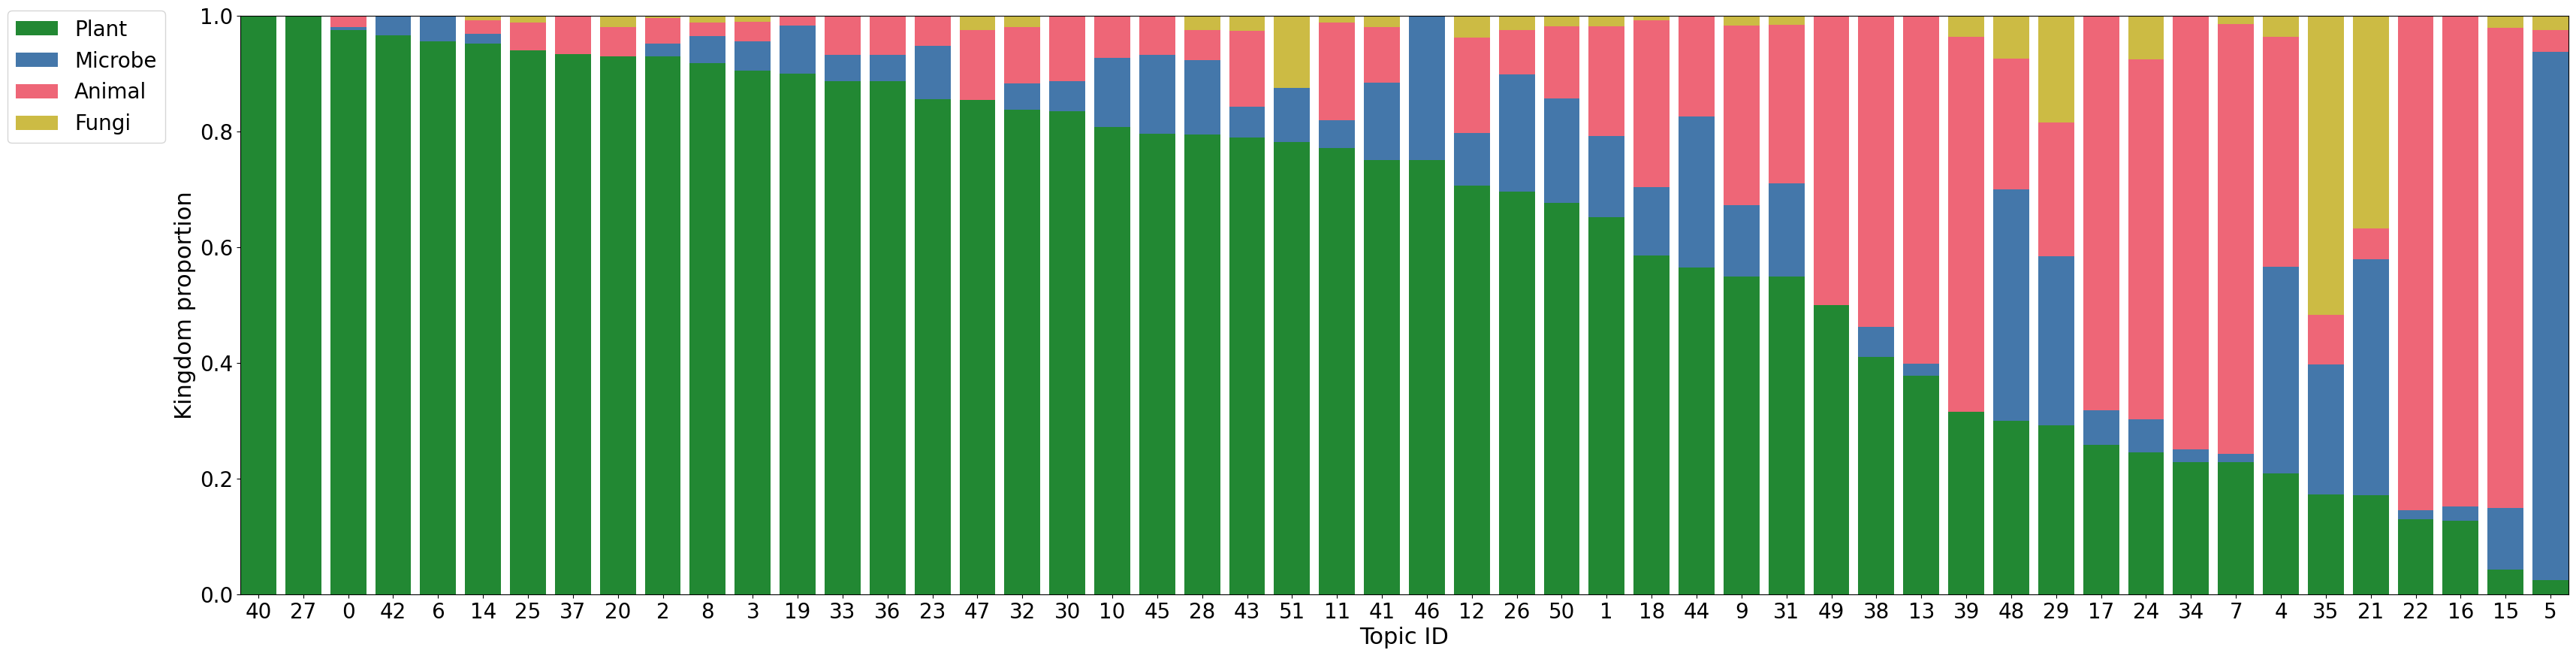

In [24]:
colors = {'Plant': '#228833', 'Animal':'#EE6677', 'Microbe': '#4477AA', 'Fungi':'#CCBB44'}
fig, ax = plt.subplots(figsize=(40,10))
bottom = np.zeros(bars_df.shape[1])

for system in bars_df.index:
    p = ax.bar(bars_df.columns.astype(str), bars_df.loc[system], color=colors[system], label=system, bottom=bottom)
    bottom += bars_df.loc[system]

# xloc_to_xlab = {txt.get_unitless_position()[0]: txt.get_text() for txt in plt.gca().get_xticklabels()}
# for p in ax.patches:
#     width, height = p.get_width(), p.get_height()
#     x, y = p.get_xy()
#     to_label = x + 0.5*width
#     topic = xloc_to_xlab[to_label]
#     label = topic_counts[int(topic)]
#     ax.text(x+width/2, 
#             1.1, 
#             '{}'.format(label), 
#             horizontalalignment='center', 
#             verticalalignment='center',
#            fontsize=20)
plt.margins(x=0, tight=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Topic ID', fontsize=22)
plt.ylabel('Kingdom proportion', fontsize=22)
plt.legend(fontsize=20, loc=(-0.1, 0.78))

plt.savefig('../data/citation_network/figures/vertical_topic_admixture.png', format='png', bbox_inches='tight', dpi=600)

What are the topic clusters that are plant only versus those that have better distribution? Let's try making this figure horixzontally with the topic representations as the x labels.

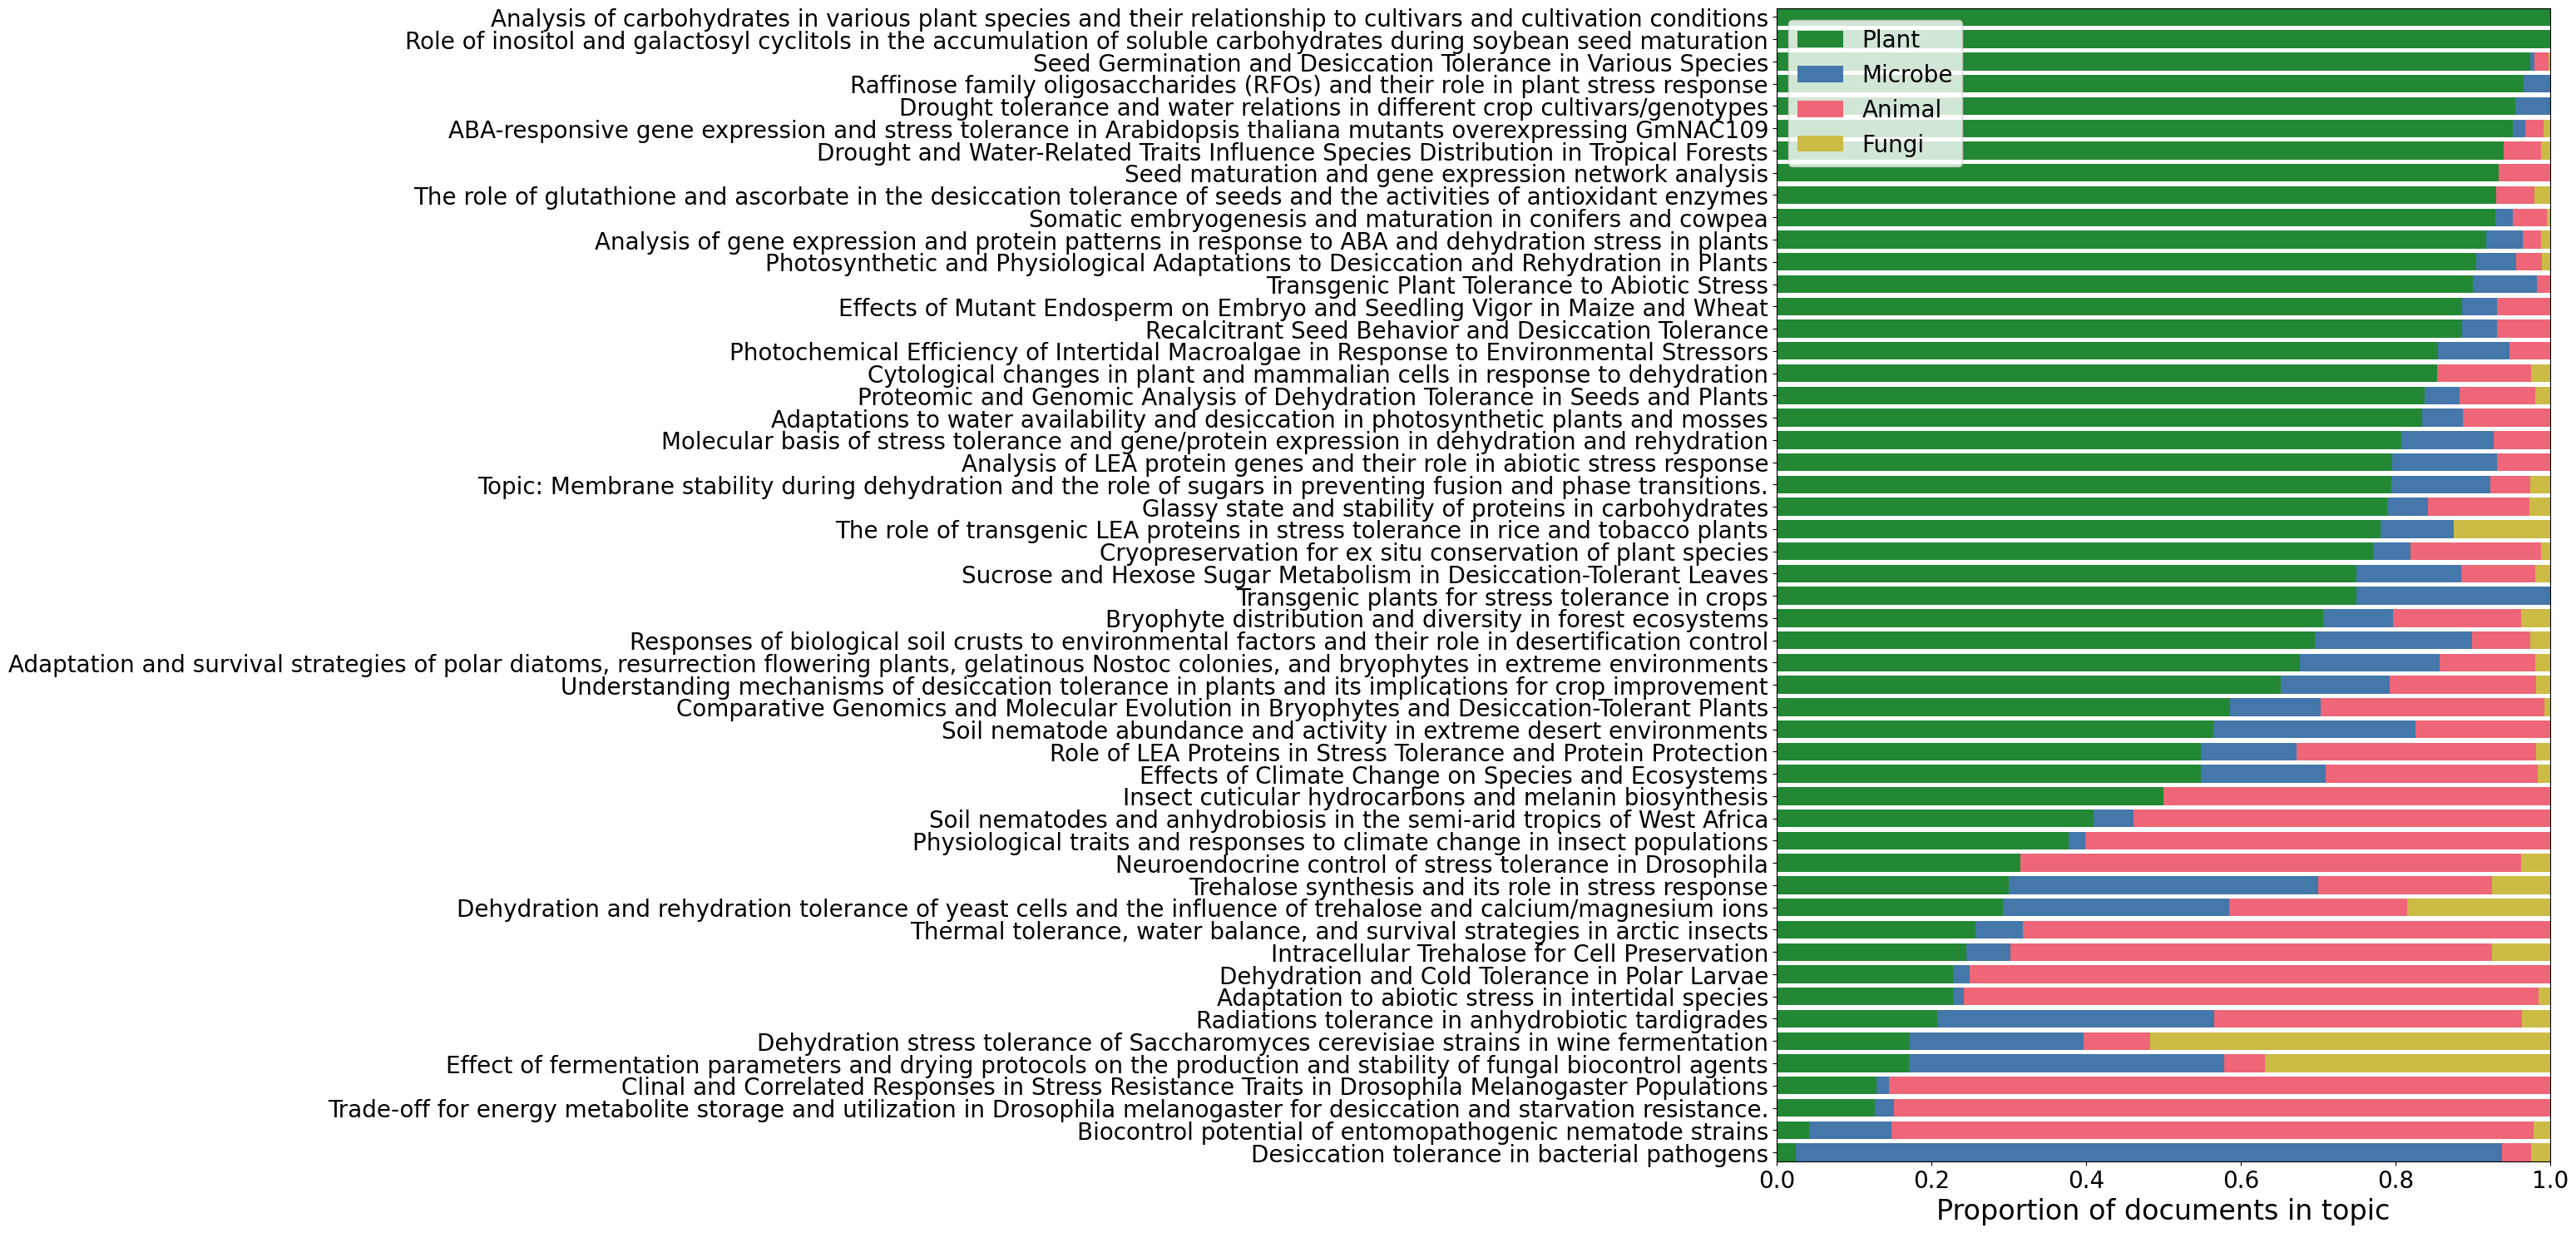

In [29]:
fig, ax = plt.subplots(figsize=(12,18))
ax.invert_yaxis()
bottom = np.zeros(bars_df.shape[1])

for system in bars_df.index:
    labs = [topic_reps[k] for k in bars_df.columns]
    p = ax.barh(labs, bars_df.loc[system], color=colors[system], label=system, left=bottom)
    bottom += bars_df.loc[system]
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Proportion of documents in topic', fontsize=24)
plt.legend(fontsize=20)
plt.margins(y=0, tight=True)
plt.savefig('../data/citation_network/figures/horizontal_topic_admixture.png', format='png', bbox_inches='tight', dpi=600)

## Dynamic topic modeling
Let's take a look at the representation of topics over time via [dynamic topic modeling](https://maartengr.github.io/BERTopic/getting_started/topicsovertime/topicsovertime.html#visualization). All we need to turn our single topic model into a dynamic topic model is to include the years of the documents. The important thing to note about this analysis is that the topic model is still fit glopbally, so the topic clusters are constant; the purpose of dynamic topic modeling is to get a view of how people *referred* to those topics over time, rather than looking at what topics existed or didn't exist, per-se. However, by looking at the frequency of documents belonging to each topic cluster across time, we can get a sense of the popularity of that topic over time.

In [ ]:
## Run to get a topic model without outlier reduction
# topic_model = BERTopic(embedding_model=sentence_model)
# topics, probs = topic_model.fit_transform(docs)
# vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)
# topic_model.update_topics(docs, vectorizer_model=vectorizer_model)

In [30]:
topics_over_time = topic_model.topics_over_time(docs, abstracts['year'], global_tuning=False, nr_bins=50)

In [31]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[0,1,2,3,4])

In [32]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[40,37,35,5,16])

In [33]:
topic_model.visualize_topics_over_time(topics_over_time, topics=[44,48,21,29])

## Hierarchical topic modeling
Another way we can look at the trends in these documents is by [hierarchical topic modeling](https://maartengr.github.io/BERTopic/getting_started/hierarchicaltopics/hierarchicaltopics.html). This groups topics according to whether there is some super-topic that could consume multiple sub-topics. Let's take a look:

In [34]:
hierarchical_topics = topic_model.hierarchical_topics(docs)

100%|██████████| 51/51 [00:00<00:00, 210.08it/s]


In [35]:
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

## Topic modeling for each discipline
In the above figures, it looks like in certain instances, topics separate on kingdoms simply because of names of kingdom organisms, like "bacterial" or "nematode". We want to look at the topics independently of the kingdom they come from, and there are two ways to go about this. The first would be to build a topic model on each kingdom alone, which we'll do here. The Fungi group has too few documents, so we'll put it aside for now.

In [ ]:
# kingdom_models = {}
# for king in ['Plant', 'Animal', 'Microbe']:
#     # Get the subset of docs belonging to the kingdom
#     abstract_sub = abstracts[abstracts['study_system'] == king]
#     docs = abstract_sub.abstract.values.tolist()
#     print(f'There are {len(docs)} documents for kingdom {king}')
    
#     # Initialize input models
#     sentence_model = SentenceTransformer('allenai/scibert_scivocab_cased')
#     umap_model = UMAP(random_state=42)
#     min_cluster_size = min(round(0.01*len(docs)), 50)
#     print(f'Estimated minimum cluster size for this number of documents is {min_cluster_size}')
#     hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size, metric='euclidean', cluster_selection_method='eom', prediction_data=True)
    
#     # Perform topic modeling
#     topic_model = BERTopic(embedding_model=sentence_model, umap_model=umap_model, hdbscan_model=hdbscan_model)
#     topics, probs = topic_model.fit_transform(docs)
#     vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 3), min_df=10)
#     topic_model.update_topics(docs, vectorizer_model=vectorizer_model)
#     kingdom_models[king] = topic_model